In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../../Grids/Periodic_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../Grids/Periodic_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../Grids/Periodic_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

def rotation(phi):
    operator = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    return operator

def translation(vector, coordinate):
    operator = vector + np.array([coordinate[0], coordinate[1]])
    return operator

def centering(vector, coordinate):
    operator = vector - np.array([coordinate[0], coordinate[1]])
    return operator

def argz(z):
    a = np.angle(z)
    if a >= 0:
        return a
    else:
        return 2*np.pi + a

# First we make sure the grid is centered by finding the center point of the grid
# Then we translate everything, placing the center point in the origin
# The center point has to be the point closest to (0.5, 0.5)
def center_finder(points,grain):
    center_point_candidates = [(ele, count) for count, ele in enumerate(points) if np.linalg.norm(ele - np.array([0.5, 0.5])) <= 10**(-grain)]

    if len(center_point_candidates) != 1:
        print('More or less than one candidate found. Consider changes to search method')
    else:
        center_point = center_point_candidates[0]
        coors = center_point[0]
        ind = center_point[1]
        return coors, ind

center_coor, center_ind = center_finder(grid_coordinates, 6)
# Translate every point through this
grid_translated = [centering(x, center_coor) for x in grid_coordinates]
jump_translated = [[centering(x, center_coor) for x in i] for i in jump_coordinates]

# Read the phases in
evec_phases = []
with open('../../Separate_files/Periodic_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()

phases_ind = [(ele, count) for count, ele in enumerate(evec_phases)]

In [3]:
def Hamil_solve(grid_coor, jump_coor, jump_ind, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(grid_coor)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    l = 0.041666666666666664
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(grid_coor, jump_coor):
        products = [i[0]*k[1] - k[0]*i[1] for k in j]
        jump_products.append(products)
    phase_factors = []
    for x, y in zip(grid_coor, jump_products):
        phases = [(phi/(2 * l**2)) * s for s in y]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_ind, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues
    eig_vals, eig_vecs = np.linalg.eigh(H)
    return eig_vals, eig_vecs

# Calculate eigenvalues for varying B field strength
max_B = (2*np.pi)/(0.041666666666666664**2)
evals, evecs = Hamil_solve(grid_translated, jump_translated, jump_indices, (0)*max_B)

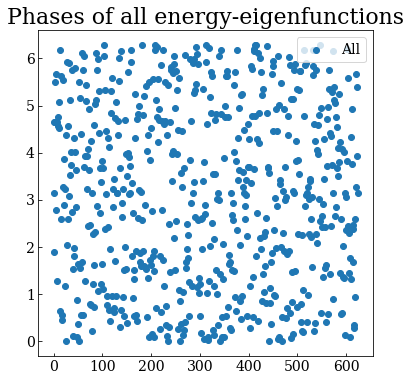

In [4]:
# Now we want to examine phases of all eigenvectors

fig, ax = plt.subplots(figsize= (6,6))

indices = np.arange(0,len(evecs))

# First we plot all phases
ax.scatter(x= indices, y= evec_phases, label= 'All')

ax.legend()
ax.set_title('Phases of all energy-eigenfunctions')
plt.show()

In [5]:
dim = len(grid_coordinates)

def time_evolve(state, time, evec, eval):

    hbar = 1
    # Calculate changes to the state chosen from relevant Bott indice = 1 being index 81

    phi0 = np.zeros(len(eval), dtype= np.complex128)
    phi0[state] = 1

    # Define the time evolution a state 
    # We take the inner product of localised particle and all eigenstates of the hamilton
    # The coefficients will be used for creating phi as a linear combination of eigenstates
    cns = [np.vdot(x, phi0) for x in evec]

    # We can write phi in the basis of eigenstates for the hamiltonian
    # This amounts to selecting cns where the bott index is B != 0
    phi = np.zeros(len(eval), dtype= np.complex128)
    for i, ele in enumerate(cns):
        phi[i] = ele

    phi_norm_initial = phi / (np.sqrt(np.vdot(phi,phi)))

    # Now we define the Hamiltonian as a diagonal matrix since we have written phi in the basis of eigenstates, thus it will simplify our work
    # We set some timestep t
    t = time
    # Now we construct the time evolution operator by exponentiating every diag entry
    time_op = np.diag([np.exp(-1j*((dval)/(hbar))*t) for dval in eval])
    # Now we apply the time evolution operator to phi
    phi_evolve = np.matmul(time_op, phi_norm_initial)

    # We would like to know what phi is now in the basis of lattice sites. To do this we construct coordinate transformation matrix
    # Start by calculating the inner produts of vdot(ei, sk) for all k this will be the i'th column. s denotes site vectors
    # Site vectors have one entry equal to 1 while the rest are equal to 0. Thus the i,k'th inner product is just selecting the k'th value the i'th vectors complex conjugate
    # This means the coordinate transformation matrix ith column is just the ith eigenvector
    T = np.zeros((len(eval), len(eval)), dtype= np.complex128)
    for i in range(len(eval)):
        T[:, i] = evec[i]
    # Now we can transform phi_evolve into the basis of lattice sites
    phi_lat = np.matmul(T,phi_evolve)
    # phi is normalised 
    phi_norm = phi_lat / (np.sqrt(np.vdot(phi_lat,phi_lat)))
    density_of_states = [x.real for x in phi_norm.conj() * phi_norm]
    return phi_norm, density_of_states

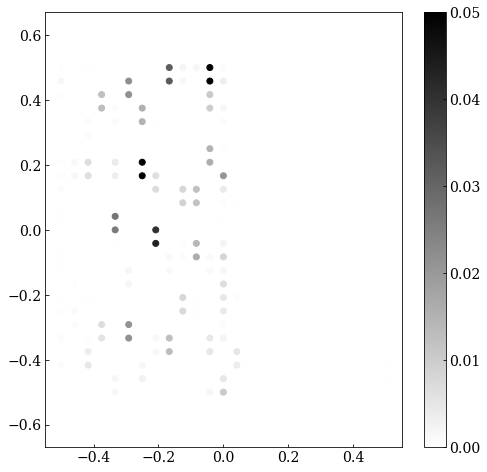

In [6]:
## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

# Set figure up first
fig, ax = plt.subplots(figsize=(8,8))
# Set bascis
sites = ax.scatter(x=[], y=[], c=[])

xs = [w[0] for w in grid_translated]
ys = [w[1] for w in grid_translated]

# Set timesteps, state of choice for animation, and number of frames
timestep = 0.1
n_frames = 100

psi_0, dos_0 = time_evolve(0, 0, evecs, evals)

dos_max = (1/20)*max(dos_0)

plt.set_cmap('binary')
#cax = ax.scatter(x= xs, y= ys, s= marker_size, c= dos_max, zorder= 2)


# This function will do the animating
def update(i):
    plt.clf()
    # t is the steps we progress, timestep sets the steplength
    t = i * timestep

    # Using the time evolution to find density of states for each increment
    psi, dos = time_evolve(0, t, evecs, evals)
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
    plt.colorbar(cf)
    plt.axis('equal')


anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

#name = '_'+''.join([str(ele) + '_' for ele in group_of_choice])

#anim.save(f'Pe_BLT_time_evolve/{name}states.gif', writer='imagemagick', fps=15)

anim